In [1]:
import numpy as np
import dask
from pathlib import Path
from ViennaRNA import RNA
import pandas as pd
from dask.distributed import Client
from multiprocessing import cpu_count
n_cores = cpu_count()
print(n_cores)
from dask.distributed import progress
client = Client()
client

48


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 48,Total memory: 125.66 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43139,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 48
Started: Just now,Total memory: 125.66 GiB
Comm: tcp://127.0.0.1:36845,Total threads: 6
Dashboard: http://127.0.0.1:41419/status,Memory: 15.71 GiB
Nanny: tcp://127.0.0.1:35537,


### client

In [2]:
class CFG:
    path = Path('../data/')

In [3]:
import dask.dataframe as dd

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:


# # Function to perform RNA secondary structure prediction on a Pandas DataFrame
# def predict_structure(df):
#     df['ss_full'], df['ss_full_mfe'] = zip(*df['sequence'].apply(lambda x: RNA.fold_compound(x).mfe()))
#     return df



In [ ]:


def read_and_filter_parquet(file_path):
    df = dd.read_parquet(file_path)
    df_filtered = df[['sequence_id', 'sequence']]
    df_filtered = df_filtered.drop_duplicates(subset=['sequence_id'])
    return df_filtered

def predict_structure(df):
    df['ss_full'], df['ss_full_mfe'] = zip(*df['sequence'].apply(lambda x: RNA.fold_compound(x).mfe()))
    df['ss_roi'], df['ss_roi_mfe'] = zip(*df['sequence'].apply(lambda x: RNA.fold_compound(x[26:-21]).mfe()))
    return df

# File path configuration (replace with your own path)
# Read and filter the DataFrame
dask_df_filtered = read_and_filter_parquet(CFG.path/'train_data.parquet')

# Repartition DataFrame to have as many partitions as cores
dask_df_filtered = dask_df_filtered.repartition(npartitions=32)

# Sample 100% of the rows (i.e., keep all rows)
sampled_dask_df = dask_df_filtered.sample(frac=1.0, random_state=42)

# Metadata for new columns
meta = sampled_dask_df._meta.assign(
    ss_full=pd.Series(dtype='str'), 
    ss_full_mfe=pd.Series(dtype='float64'),
    ss_roi=pd.Series(dtype='str'),
    ss_roi_mfe=pd.Series(dtype='float64')
)

# Apply RNA secondary structure prediction
predicted_dask_df = sampled_dask_df.map_partitions(predict_structure, meta=meta)

# Show progress (this will work if you are in a Jupyter Notebook)
progress(predicted_dask_df)

# Compute to get the result
predicted_df = predicted_dask_df.compute()

# Print the result
print(predicted_df)

# Close the Dask Client
client.close()
predicted_df.to_parquet('train_ss_vienna_rna.parquet', index=False)

In [4]:


def read_and_filter_parquet(file_path):
    df = dd.read_csv(file_path)
    df_filtered = df[['sequence_id', 'sequence']]
    df_filtered = df_filtered.drop_duplicates(subset=['sequence_id'])
    return df_filtered

def predict_structure(df):
    df['ss_full'], df['ss_full_mfe'] = zip(*df['sequence'].apply(lambda x: RNA.fold_compound(x).mfe()))
    df['ss_roi'], df['ss_roi_mfe'] = zip(*df['sequence'].apply(lambda x: RNA.fold_compound(x[26:-21]).mfe()))
    return df

# File path configuration (replace with your own path)
# Read and filter the DataFrame
dask_df_filtered = read_and_filter_parquet(CFG.path/'test_sequences.csv')

# Repartition DataFrame to have as many partitions as cores
dask_df_filtered = dask_df_filtered.repartition(npartitions=32)

# Sample 100% of the rows (i.e., keep all rows)
sampled_dask_df = dask_df_filtered

# Metadata for new columns
meta = sampled_dask_df._meta.assign(
    ss_full=pd.Series(dtype='str'), 
    ss_full_mfe=pd.Series(dtype='float64'),
    ss_roi=pd.Series(dtype='str'),
    ss_roi_mfe=pd.Series(dtype='float64')
)

# Apply RNA secondary structure prediction
predicted_dask_df = sampled_dask_df.map_partitions(predict_structure, meta=meta)

# Show progress (this will work if you are in a Jupyter Notebook)
progress(predicted_dask_df)

# Compute to get the result
predicted_df = predicted_dask_df.compute()

# Print the result
print(predicted_df)

# Close the Dask Client
client.close()
predicted_df.to_parquet('test_ss_vienna_rna.parquet', index=False)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


         sequence_id                                           sequence  \
0       eee73c1836bc  GGGAACGACUCGAGUAGAGUCGAAAAUUUCCUUCCAAAUCCUGAGG...   
1       d2a929af7a97  GGGAACGACUCGAGUAGAGUCGAAAAUGUAAUCAGAUUGCUUCUCC...   
2       d39a4425ff45  GGGAACGACUCGAGUAGAGUCGAAAAAACACAUGAAUUUGAGGGUU...   
3       1fc41e92d553  GGGAACGACUCGAGUAGAGUCGAAAAUCAGAGCUGGCAAAUGGAUG...   
4       1d0826fb892f  GGGAACGACUCGAGUAGAGUCGAAAAUUUGGUAUUUGAUGCAUUAA...   
...              ...                                                ...   
319115  3cf515909422  GGGAACGACUCGAGUAGAGUCGAAAAGGAGGGAAAAGUUAUCAGGC...   
319116  3606852d6c2b  GGGAACGACUCGAGUAGAGUCGAAAAGGAGGGAAAAGUUAUCAGGC...   
319117  49b9448fd455  GGGAACGACUCGAGUAGAGUCGAAAAGGAGGGAAAAGUUAUCAGGC...   
319118  eb9bd6372550  GGGAACGACUCGAGUAGAGUCGAAAAGGAGGGAAAAGUUAUCAGGC...   
319119  0dd65209259b  GGGAACGACUCGAGUAGAGUCGAAAAGGAGGGAAAAGUUAUCAGGC...   

                                                  ss_full  ss_full_mfe  \
0       .....((((((.....)

In [5]:
predicted_df

,sequence_id,sequence,ss_full,ss_full_mfe,ss_roi,ss_roi_mfe
0,eee73c1836bc,GGGAACGACUCGAGUAGAGUCGAAAAUUUCCUUCCAAAUCCUGAGG...,.....((((((.....))))))....((((((((........))))...,-77.800003,((((((((........)))))))).....((((((((((....(((...,-68.000000
1,d2a929af7a97,GGGAACGACUCGAGUAGAGUCGAAAAUGUAAUCAGAUUGCUUCUCC...,.....((((((.....)))))).............(((((...(((...,-52.500000,.........(((((...(((((((((((((...((((.((((((((...,-42.799999
2,d39a4425ff45,GGGAACGACUCGAGUAGAGUCGAAAAAACACAUGAAUUUGAGGGUU...,.....((((((.....))))))..........((...((((((......,-51.400002,......((...((((((........))))))...))......((((...,-40.900002
3,1fc41e92d553,GGGAACGACUCGAGUAGAGUCGAAAAUCAGAGCUGGCAAAUGGAUG...,((((.((((((.....)))))).......(((..((((((.(..((...,-68.500000,...(((..((((((.(..((((..((.(((((....)))))..)))...,-55.799999
4,1d0826fb892f,GGGAACGACUCGAGUAGAGUCGAAAAUUUGGUAUUUGAUGCAUUAA...,.....((((((.....))))))....(((((((......(((((((...,-50.500000,(((((((......(((((((..(((((...(((((.((.(((((.....,-40.700001
...,...,...,...,...,...,...
319115,3cf515909422,GGGAACGACUCGAGUAGAGUCGAAAAGGAGGGAAAAGUUAUCAGGC...,.....((((((.....))))))..((((((((...((((((((((....,-158.699997,.((.((...((((((((((......)))))))))).((((((((((...,-147.399994
319116,3606852d6c2b,GGGAACGACUCGAGUAGAGUCGAAAAGGAGGGAAAAGUUAUCAGGC...,.....((((((.....))))))..((((((((...((((((((((....,-158.100006,.((.((...((((((((((......)))))))))).((((((((((...,-146.800003
319117,49b9448fd455,GGGAACGACUCGAGUAGAGUCGAAAAGGAGGGAAAAGUUAUCAGGC...,.....((((((.....))))))..((((((((...((((((((((....,-159.000000,..(((((..((((((((((......))))))))))..)))))...(...,-148.500000
319118,eb9bd6372550,GGGAACGACUCGAGUAGAGUCGAAAAGGAGGGAAAAGUUAUCAGGC...,.....((((((.....))))))..((((((((...((((((((((....,-164.600006,..(((((..((((((((((......))))))))))..)))))...(...,-153.399994


In [1]:
from ViennaRNA import RNA

In [2]:
def predict_bpp(sequence):
    """
    Predicts base pairing probabilities (BPP) for a given RNA sequence.
    
    Parameters:
    - sequence (str): The RNA sequence.
    
    Returns:
    - bpp (list of lists): A matrix containing base pairing probabilities.
    """
    # Create a fold_compound object from the RNA sequence
    fc = RNA.fold_compound(sequence)
    
    # Compute the MFE and the corresponding secondary structure
    (mfe_structure, mfe) = fc.mfe()
    
    # Compute the base pairing probability matrix
    bpp = fc.bpp()
    
    return bpp

In [5]:
predict_bpp('UAAAAAAAUUUUU')

()

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [43]:
def predict_bpp(sequence):
    """
    Predicts base pairing probabilities (BPP) for a given RNA sequence.
    
    Parameters:
    - sequence (str): The RNA sequence.
    
    Returns:
    - bpp (list of lists): A matrix containing base pairing probabilities.
    """
    # Create a fold_compound object from the RNA sequence
    fc = RNA.fold_compound(sequence)
    
    # Compute the partition function to get the bpp matrix
    fc.pf()
    bpp_matrix = fc.bpp()
    
    # Convert the bpp_matrix to a typical 2D Python list
    bpp = [[0 for j in range(len(sequence))] for i in range(len(sequence))]
    
    for i in range(len(sequence)):
        for j in range(i+1, len(sequence)):
            # Access the bpp_matrix to get the probability
            bpp[i][j] = bpp_matrix[i][j-i-1]
    
    return np.array(bpp)

In [31]:
sequence = "GCAUCUAUGUACUAGCUGAUCG"
bpp_matrix = predict_bpp(sequence)

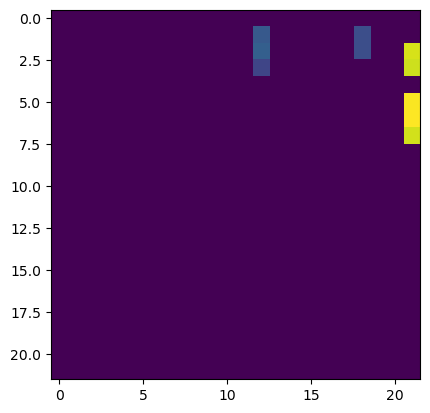

In [36]:
plt.imshow(np.array(bpp_matrix))

In [40]:
df = pd.read_parquet('train_ss_vienna_rna.parquet')
row = df.iloc[54]

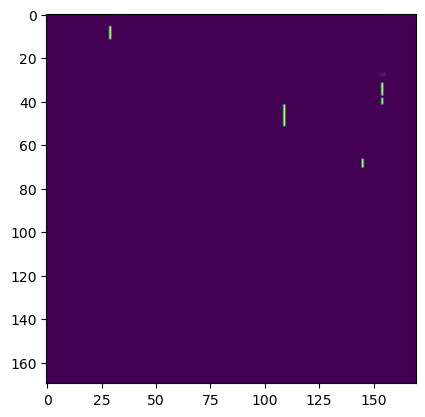

In [45]:
plt.imshow(predict_bpp(row['sequence']))